# Data Exploration 

Objective: Understand the data structure, identify patterns, and validate
          temporal consistency before feature engineering.

Investigation Questions:
1. Is the data temporally ordered?
2. Are there missing patterns (systematic vs random)?
3. What's the distribution of our target variable?
4. Do patterns differ by position?
5. Are there data quality issues?

## CONFIGURATION

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Path configuration
BASE_DIR = Path.cwd().parent
PROCESSED_DIR = BASE_DIR / "data" / "processed"
DATA_FILE = PROCESSED_DIR / "fpl_unified_preprocessed.csv"

# Load preprocessed data
df = pd.read_csv(DATA_FILE)
print(f"Dataset Shape: {df.shape}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

C:\Users\kadmi\AppData\Local\Temp\ipykernel_17788\3148591554.py:16: DtypeWarning: Columns (33,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_FILE)


Dataset Shape: (102197, 50)
Memory Usage: 78.56 MB


## 1. Temporal Structure Analysis

In [13]:
# Verify temporal ordering
df['season_gw'] = df['season'] + '_GW' + df['GW'].astype(str)
print("Temporal Coverage:")
print(df.groupby('season')['GW'].agg(['min', 'max', 'count']))

# Check for gaps in gameweeks
print("\nGameweek Continuity Check:")
for season in df['season'].unique():
    season_gws = df[df['season'] == season]['GW'].unique()
    expected = set(range(1, season_gws.max() + 1))
    actual = set(season_gws)
    missing = expected - actual
    if missing:
        print(f"{season}: Missing GWs {sorted(missing)}")
    else:
        print(f"{season}: Complete (GW 1-{season_gws.max()})")

Temporal Coverage:
         min  max  count
season                  
2021-22    1   38  23230
2022-23    1   38  24957
2023-24    1   38  28742
2024-25    1   21  14178
2025-26    1   15  11090

Gameweek Continuity Check:
2021-22: Complete (GW 1-38)
2022-23: Missing GWs [7]
2023-24: Complete (GW 1-38)
2024-25: Complete (GW 1-21)
2025-26: Complete (GW 1-15)


## 2. Target Variable Distribution Analysis

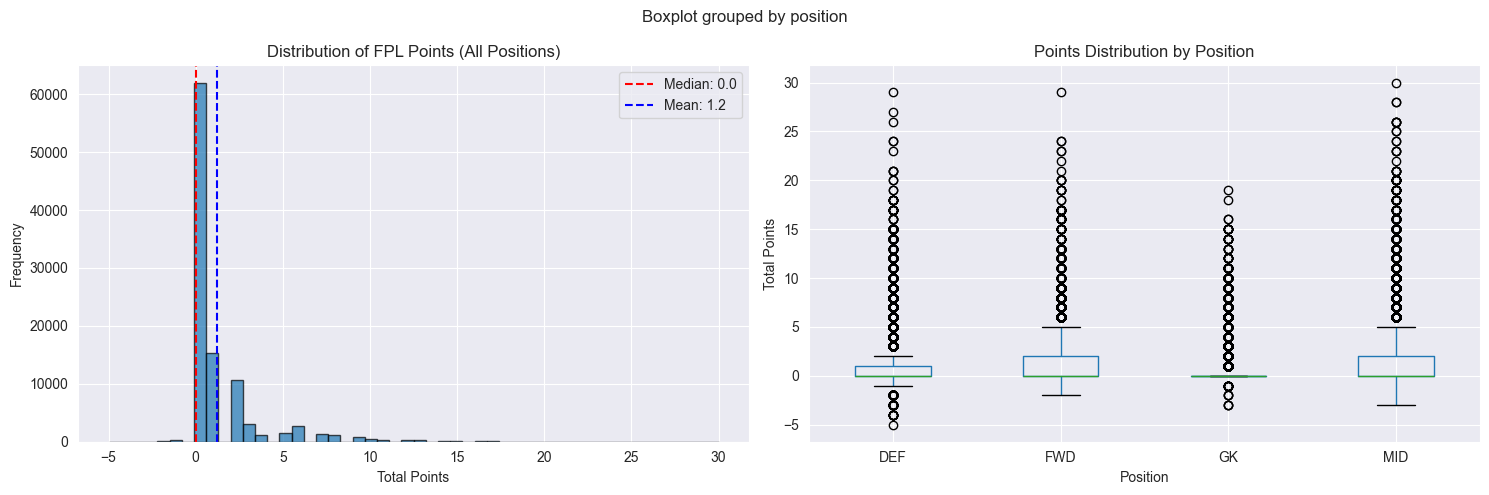


Target Variable Statistics:
            count      mean       std  min  25%  50%  75%   max
position                                                       
DEF       34189.0  1.154348  2.429505 -5.0  0.0  0.0  1.0  29.0
FWD       12519.0  1.368879  2.747663 -2.0  0.0  0.0  2.0  29.0
GK        11342.0  0.913860  2.142792 -3.0  0.0  0.0  0.0  19.0
MID       44147.0  1.317666  2.501416 -3.0  0.0  0.0  2.0  30.0


In [14]:
# Distribution of points (our target)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall distribution
axes[0].hist(df['total_points'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(df['total_points'].median(), color='red', linestyle='--', 
                label=f'Median: {df["total_points"].median():.1f}')
axes[0].axvline(df['total_points'].mean(), color='blue', linestyle='--',
                label=f'Mean: {df["total_points"].mean():.1f}')
axes[0].set_xlabel('Total Points')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of FPL Points (All Positions)')
axes[0].legend()

# By position
df.boxplot(column='total_points', by='position', ax=axes[1])
axes[1].set_title('Points Distribution by Position')
axes[1].set_xlabel('Position')
axes[1].set_ylabel('Total Points')

plt.tight_layout()
plt.show()

print("\nTarget Variable Statistics:")
print(df.groupby('position')['total_points'].describe())


In [15]:
# Zero-inflation analysis (players who didn't play)
zero_points_pct = (df['total_points'] == 0).sum() / len(df) * 100
zero_minutes_pct = (df['minutes'] == 0).sum() / len(df) * 100

print(f"\nZero Points: {zero_points_pct:.2f}% of observations")
print(f"Zero Minutes: {zero_minutes_pct:.2f}% of observations")
print("Note: Zero points often correlate with not playing (minutes=0)")



Zero Points: 60.52% of observations
Zero Minutes: 58.29% of observations
Note: Zero points often correlate with not playing (minutes=0)


## 3. Missing Data Forensics

In [16]:
# Missing value analysis
missing_summary = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Pct': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing_Count', ascending=False)

print("Missing Values by Column:")
print(missing_summary[missing_summary['Missing_Count'] > 0])

Missing Values by Column:
                                 Missing_Count  Missing_Pct
clearances_blocks_interceptions          91107        89.15
defensive_contribution                   91107        89.15
recoveries                               91107        89.15
tackles                                  91107        89.15
modified                                 76929        75.28
starts                                   25761        25.21
expected_goals                           23230        22.73
expected_assists                         23230        22.73
expected_goals_conceded                  23230        22.73
expected_goal_involvements               23230        22.73
round                                    15838        15.50
xP                                       15838        15.50
opponent_team                             4748         4.65
transfers_balance                         4748         4.65
was_home                                  4748         4.65
team_h_score  

In [17]:
# Expected goals missing pattern (systematic in 2021-22)
xg_cols = ['expected_goals', 'expected_assists', 'expected_goal_involvements', 
           'expected_goals_conceded']

print("\nExpected Goals Availability by Season:")
for col in xg_cols:
    if col in df.columns:
        print(f"\n{col}:")
        print(df.groupby('season')[col].apply(lambda x: f"{x.notna().sum()} / {len(x)} ({x.notna().mean()*100:.1f}%)"))


Expected Goals Availability by Season:

expected_goals:
season
2021-22          0 / 23230 (0.0%)
2022-23    24957 / 24957 (100.0%)
2023-24    28742 / 28742 (100.0%)
2024-25    14178 / 14178 (100.0%)
2025-26    11090 / 11090 (100.0%)
Name: expected_goals, dtype: object

expected_assists:
season
2021-22          0 / 23230 (0.0%)
2022-23    24957 / 24957 (100.0%)
2023-24    28742 / 28742 (100.0%)
2024-25    14178 / 14178 (100.0%)
2025-26    11090 / 11090 (100.0%)
Name: expected_assists, dtype: object

expected_goal_involvements:
season
2021-22          0 / 23230 (0.0%)
2022-23    24957 / 24957 (100.0%)
2023-24    28742 / 28742 (100.0%)
2024-25    14178 / 14178 (100.0%)
2025-26    11090 / 11090 (100.0%)
Name: expected_goal_involvements, dtype: object

expected_goals_conceded:
season
2021-22          0 / 23230 (0.0%)
2022-23    24957 / 24957 (100.0%)
2023-24    28742 / 28742 (100.0%)
2024-25    14178 / 14178 (100.0%)
2025-26    11090 / 11090 (100.0%)
Name: expected_goals_conceded, dtype: o

## 4. Player Activity Patterns

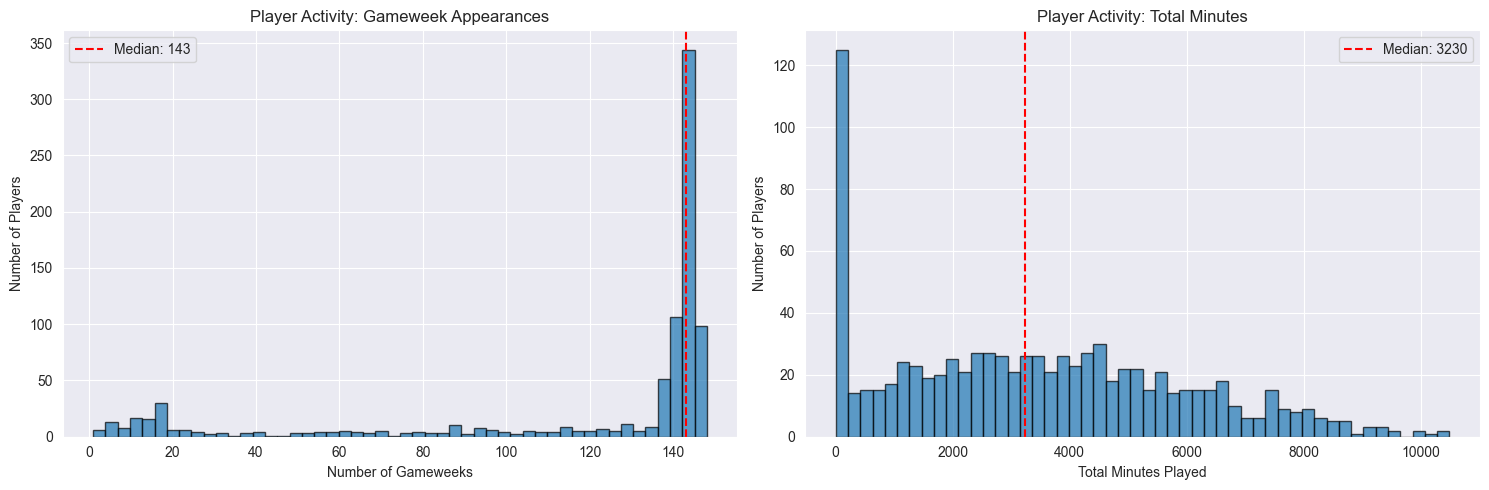


Player Activity Summary:
       appearances       minutes  total_points
count   866.000000    866.000000    866.000000
mean    118.010393   3411.347575    144.502309
std      45.671976   2491.686302    111.181810
min       1.000000      0.000000      0.000000
25%     114.000000   1351.750000     50.250000
50%     143.000000   3229.500000    132.000000
75%     144.000000   5156.000000    218.000000
max     148.000000  10491.000000    589.000000


In [18]:
# How many gameweeks does each player appear in?
player_activity = df.groupby('element').agg({
    'GW': 'count',
    'minutes': 'sum',
    'total_points': 'sum'
}).rename(columns={'GW': 'appearances'})

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Appearances distribution
axes[0].hist(player_activity['appearances'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Gameweeks')
axes[0].set_ylabel('Number of Players')
axes[0].set_title('Player Activity: Gameweek Appearances')
axes[0].axvline(player_activity['appearances'].median(), color='red', 
                linestyle='--', label=f'Median: {player_activity["appearances"].median():.0f}')
axes[0].legend()

# Total minutes distribution
axes[1].hist(player_activity['minutes'], bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Total Minutes Played')
axes[1].set_ylabel('Number of Players')
axes[1].set_title('Player Activity: Total Minutes')
axes[1].axvline(player_activity['minutes'].median(), color='red',
                linestyle='--', label=f'Median: {player_activity["minutes"].median():.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nPlayer Activity Summary:")
print(player_activity.describe())

## 5. Position-Specific Patterns

C:\Users\kadmi\AppData\Local\Temp\ipykernel_17788\461600701.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_data['time_idx'] = range(len(pos_data))
C:\Users\kadmi\AppData\Local\Temp\ipykernel_17788\461600701.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_data['time_idx'] = range(len(pos_data))
C:\Users\kadmi\AppData\Local\Temp\ipykernel_17788\461600701.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

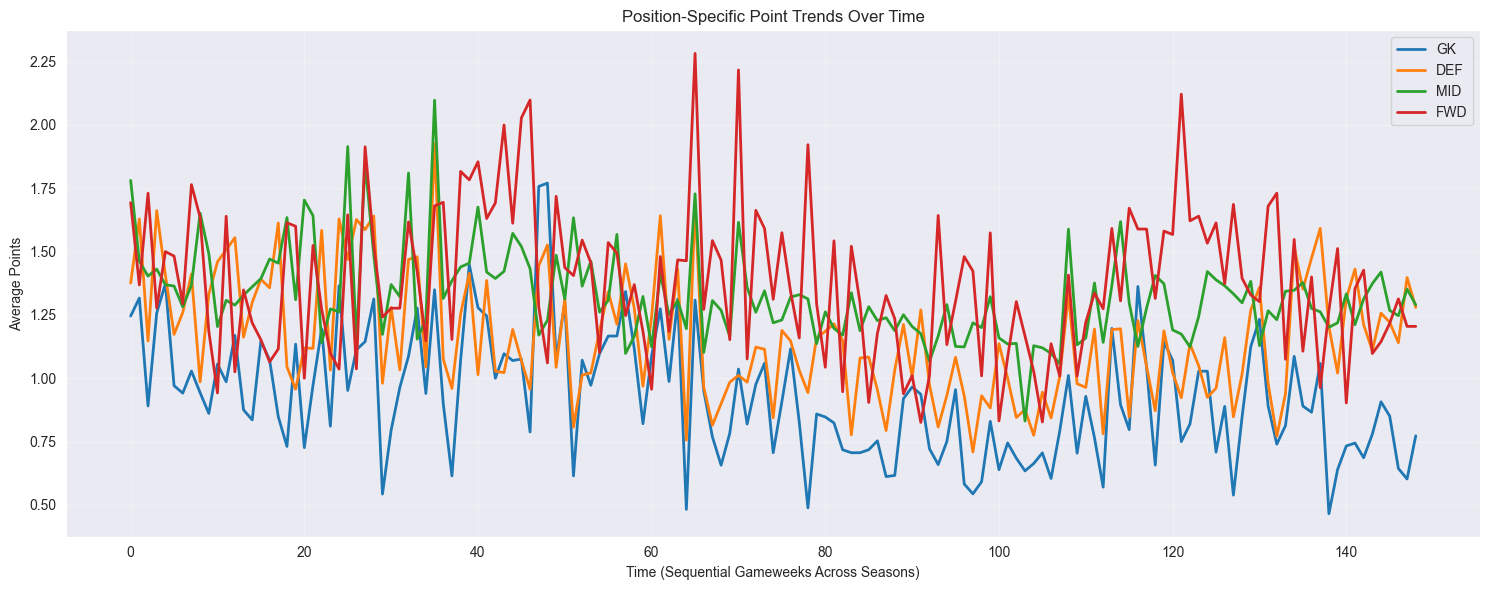

In [19]:
# Average points by position over time
position_trends = df.groupby(['season', 'GW', 'position'])['total_points'].mean().reset_index()

fig, ax = plt.subplots(figsize=(15, 6))
for position in ['GK', 'DEF', 'MID', 'FWD']:
    pos_data = position_trends[position_trends['position'] == position]
    pos_data['time_idx'] = range(len(pos_data))
    ax.plot(pos_data['time_idx'], pos_data['total_points'], label=position, linewidth=2)

ax.set_xlabel('Time (Sequential Gameweeks Across Seasons)')
ax.set_ylabel('Average Points')
ax.set_title('Position-Specific Point Trends Over Time')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

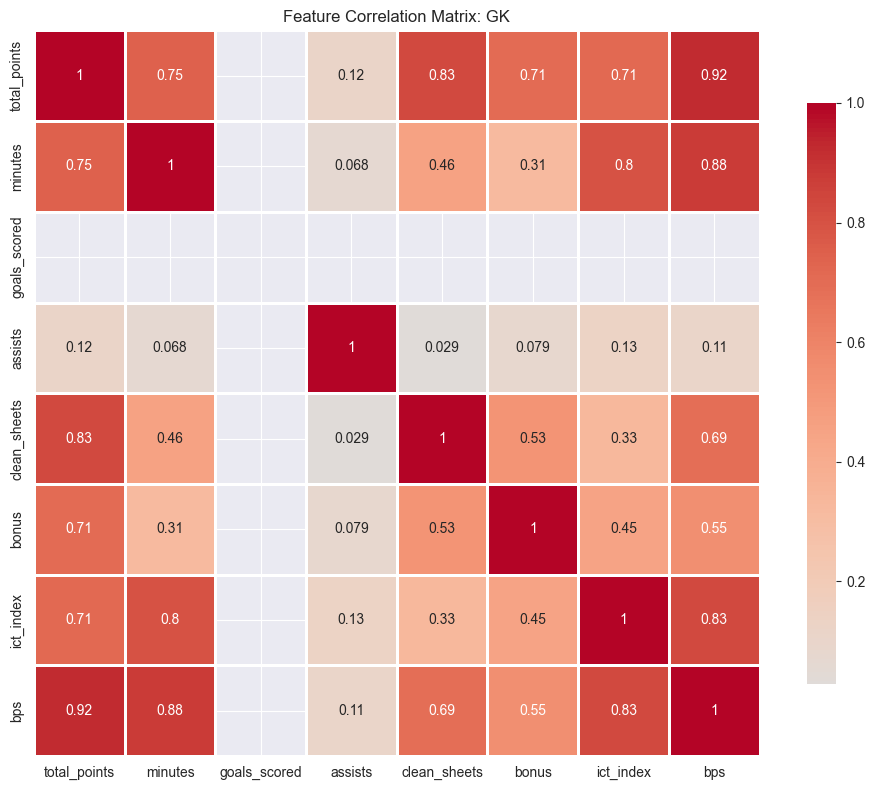

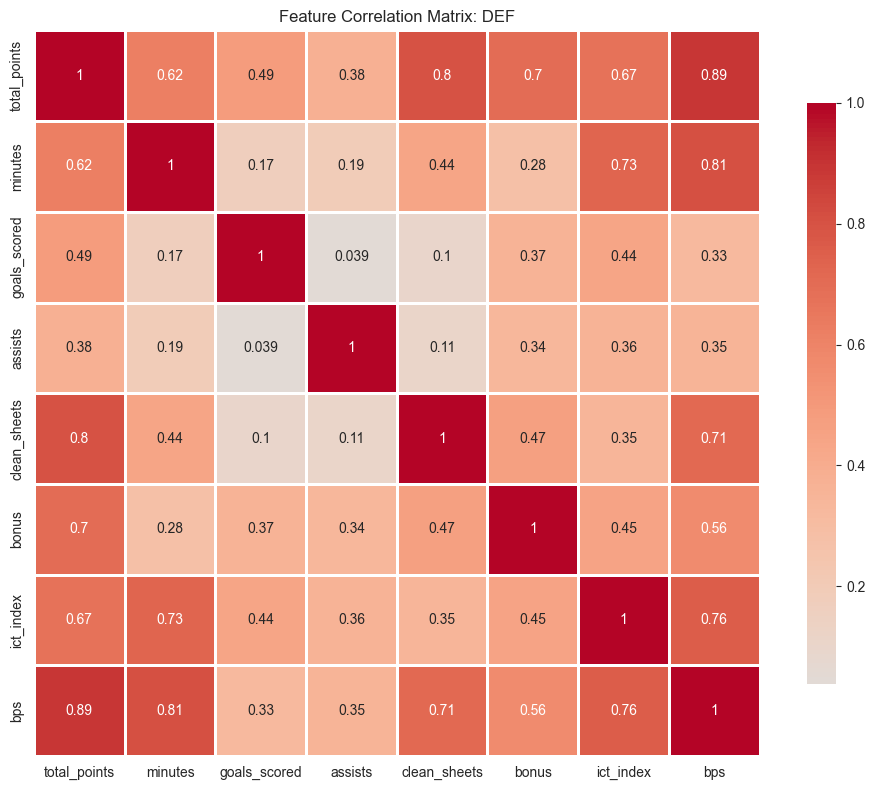

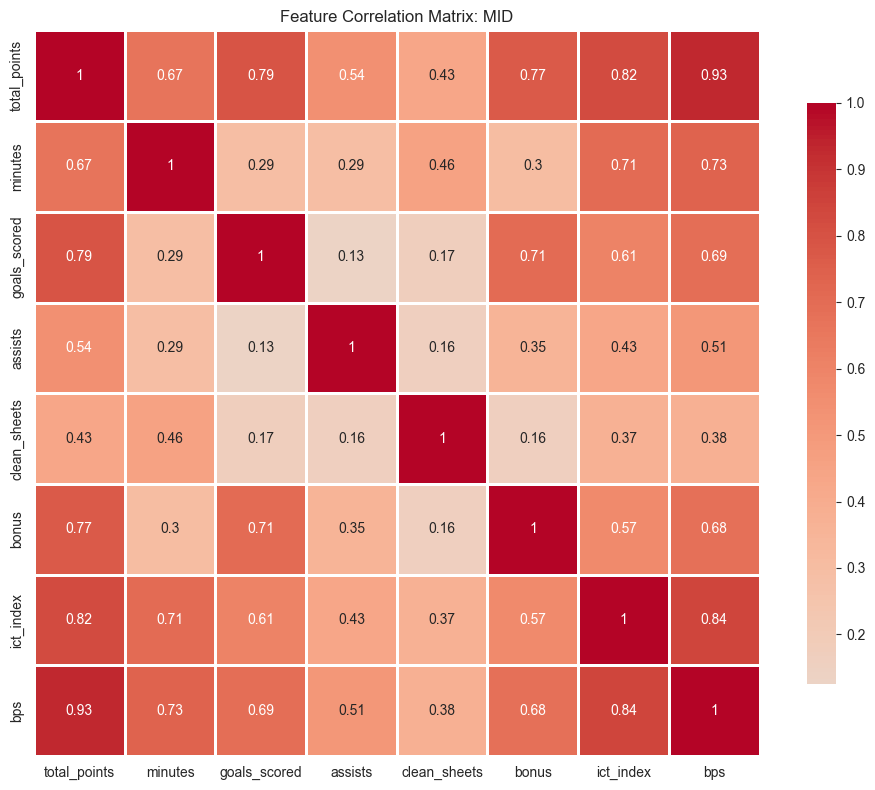

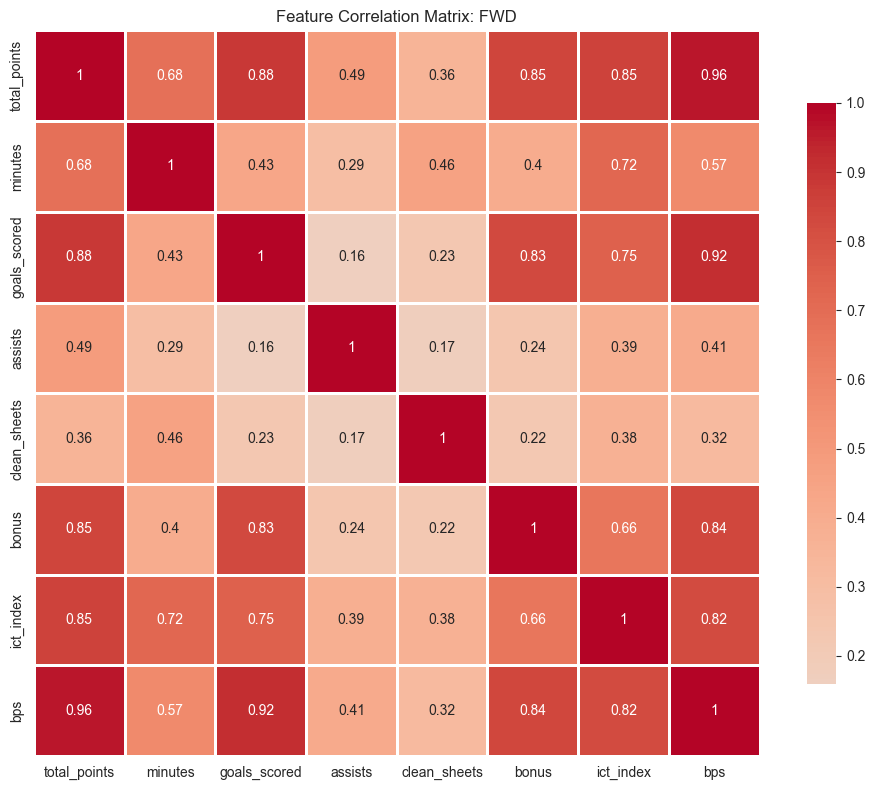

In [20]:
# Correlation between key metrics (by position)
metrics = ['total_points', 'minutes', 'goals_scored', 'assists', 
           'clean_sheets', 'bonus', 'ict_index', 'bps']

available_metrics = [col for col in metrics if col in df.columns]

for position in ['GK', 'DEF', 'MID', 'FWD']:
    pos_df = df[df['position'] == position][available_metrics]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(pos_df.corr(), annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title(f'Feature Correlation Matrix: {position}')
    plt.tight_layout()
    plt.show()

## 6. Data Quality Checks

In [21]:
# Check for impossible values
print("Data Quality Checks:")
print(f"Negative points: {(df['total_points'] < 0).sum()}")
print(f"Minutes > 90: {(df['minutes'] > 90).sum()}")
print(f"Goals > 5 (single match): {(df['goals_scored'] > 5).sum()}")

# Check for duplicate player-gameweek records
duplicates = df.duplicated(subset=['element', 'GW', 'season'], keep=False)
print(f"Duplicate player-gameweek records: {duplicates.sum()}")

if duplicates.sum() > 0:
    print("\nSample of duplicates:")
    print(df[duplicates][['element', 'name', 'season', 'GW', 'total_points', 'fixture']].head(10))

Data Quality Checks:
Negative points: 479
Minutes > 90: 1292
Goals > 5 (single match): 0
Duplicate player-gameweek records: 0
